In [44]:
# IMPORT

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [45]:
# LOAD DATASET

dataset = pd.read_csv('cars.csv')

In [46]:
# CREATE AND PLOT CARS

class Car:
    def __init__(self, data):
        self.max_power = data['max_power(bhp)']
        self.price     = data['price(in lakhs)']

cars = []

for _, row in dataset.iterrows():
    car = Car(row)
    cars.append(car)

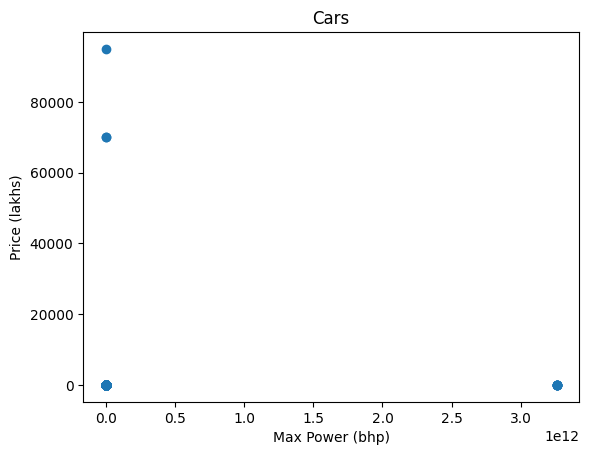

In [47]:
# PLOT CARS

def plot_data():
    plt.scatter([car.max_power for car in cars], [car.price for car in cars])
    plt.xlabel('Max Power (bhp)')
    plt.ylabel('Price (lakhs)')
    plt.title('Cars')
    plt.show()

plot_data()

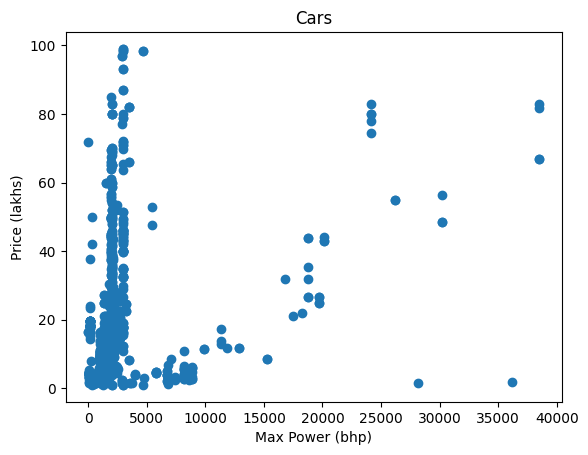

In [48]:
# FILTER BAD DATA

cars = [car for car in cars if car.max_power < 1e5 and car.price < 1e3]
plot_data()

In [49]:
# SETUP REGRESSION MODEL

class RegressionModel:
    def __init__(self):
        self.w = 0
        self.b = 0

    def predict(self, x):
        return self.w * x + self.b

    def train(self, data, lr, epochs):
        for _ in range(epochs):
            delta_w = 0
            delta_b = 0

            for x, y in data:
                delta_w += self.predict(x) - y
                delta_b += self.predict(x) - y
                
            self.w -= lr * delta_w * x / len(data)
            self.b -= lr * delta_b / len(data)
        
    def cost(self, x, y):
        return (self.predict(x) - y) ** 2
    
    def cost_average(self, data):
        return sum([self.cost(x, y) for x, y in data]) / len(data)

model = RegressionModel()
learning_data = [(car.max_power, car.price) for car in cars]

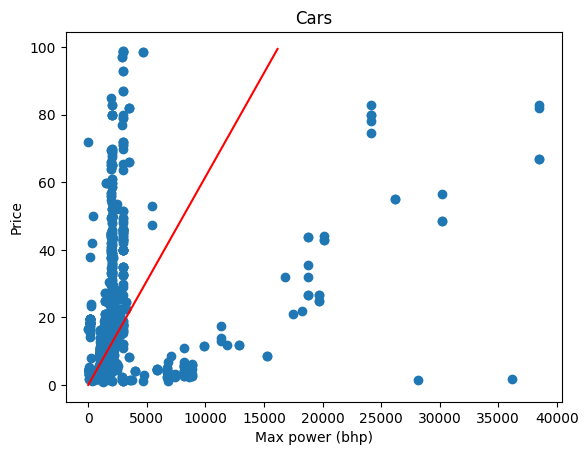

In [58]:
# TRAIN MODEL AND PLOT PROGRESS

model.train(learning_data, 0.0000001, 1)

# Plot cars
plt.scatter([car.max_power for car in cars], [car.price for car in cars])

# Plot regression line
x = np.linspace(0, 4e4, 100)
y = model.predict(x)

# Filter out points greater than or equal to 100
x, y = zip(*[(x_val, y_val) for x_val, y_val in zip(x, y) if y_val < 100])
plt.plot(x, y, '-r')

# Setup plot
plt.xlabel('Max power (bhp)')
plt.ylabel('Price')
plt.title('Cars')
plt.show() 